In [1]:
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
gen_req1 = np.load('/content/drive/My Drive/gen_req.npy')
req1 = np.load('/content/drive/My Drive/req.npy')

In [3]:
#req1 = req1[20000:2005000]
#gen_req1 = gen_req1[20000:2005000]
req1.shape,gen_req1.shape

((2005000,), (2255000,))

In [4]:
N = 100 # total ids 
pi = 3.14

LRU

In [5]:
def LRU(y, x, request_time,con):
  [N,I] = x.shape
  J = len(y)
  for j in range(J):
    x_t_j = np.zeros(N)
    file_req_time = np.zeros(N)

    # to find which users are connected to this cache 
    connected_users = []
    for k in range(I):
      if con[k,j] == 1:
        connected_users.append(k)
    for k in range(len(connected_users)):
      x_t_j += x[:,connected_users[k]]
      file_req_time = np.maximum(file_req_time, request_time[:,connected_users[k]])
    x_t_j = np.minimum(np.ones(N),x_t_j)

    a1 = np.transpose(np.logical_and(y[j],np.logical_not(np.logical_and(y[j],np.transpose(x_t_j)))))# file which is not requested but still in the cache
    b1 = np.transpose(np.logical_and(np.transpose(x_t_j),np.logical_not(np.logical_and(y[j],np.transpose(x_t_j))))) # file requested but not in the cache.
    a = np.sum(a1)
    b = np.sum(b1)

    if a>0 and b>0:
      if a>b:
        ind = []
        for k in range(N):
          if a1[k] == 1:
            ind.append(k)
        t = np.zeros(a)
        for k in range(a):
          t[k] = file_req_time[ind[k]]
        replace = (t).argsort()[:b]
        for k in range(b):
          y[j,ind[int(replace[k])]] = 0
        for k in range(N):
          if b1[k] == 1:
            y[j,k] = 1
      
      else:
        for k in range(N):
          if a1[k] == 1:
            y[j,k] = 0
        
        ind = []
        for k in range(N):
          if b1[k] == 1:
            ind.append(k)
        t = np.zeros(b)
        for k in range(b):
          t[k] = file_req_time[ind[k]]
        replace = (t).argsort()[:a]
        for k in range(a):
          y[j,ind[int(replace[k])]] = 1
  return y

LFU

In [6]:
def LFU(y,x,freq,con):
  [N,I] = x.shape
  J = len(y)

  for j in range(J):
    file_freq = np.zeros(N)
    x_t_j = np.zeros(N)

    # to find which users are connected to this cache 
    connected_users = []
    for k in range(I):
      if con[k,j] == 1:
        connected_users.append(k)
    for k in range(len(connected_users)):
      x_t_j += x[:,connected_users[k]]
      file_freq += freq[:,connected_users[k]]
    x_t_j = np.minimum(np.ones(N),x_t_j)

    a1 = np.transpose(np.logical_and(y[j],np.logical_not(np.logical_and(y[j],np.transpose(x_t_j)))))# file which is not requested but still in the cache
    b1 = np.transpose(np.logical_and(np.transpose(x_t_j),np.logical_not(np.logical_and(y[j],np.transpose(x_t_j))))) # file requested but not in the cache.
    a = np.sum(a1)
    b = np.sum(b1)
  
    if a>0 and b>0:
      if a>b:
        ind = []
        for k in range(N):
          if a1[k] == 1:
            ind.append(k)
        t = np.zeros(a)
        for k in range(a):
          t[k] = file_freq[ind[k]]
        replace = (t).argsort()[:b]
        for k in range(b):
          y[j,ind[int(replace[k])]] = 0
        for k in range(N):
          if b1[k] == 1:
            y[j,k] = 1
      else:
        for k in range(N):
          if a1[k] == 1:
            y[j,k] = 0
        ind = []
        for k in range(N):
          if b1[k] == 1:
            ind.append(k)
        t = np.zeros(b)
        for k in range(b):
          t[k] = file_freq[ind[k]]
        replace = (t).argsort()[:a]
        for k in range(a):
          y[j,ind[int(replace[k])]] = 1

  return y

perturbed count

In [7]:
def per_count(eta,count):
  [N,I] = count.shape
  p_count = np.zeros((N,I),dtype = float)
  for i in range(I):
    p_count[:,i] = count[:,i] + (eta*random.normal(0,1,[N,1])).reshape(N)
  return p_count

GREEDY

In [8]:
def Greedy(con,count):
  [I,J] = con.shape
  [N,I] = count.shape
  load = np.zeros((1,J),dtype = float)

  for i in range(I):
    for f in range(N):
      if count[f,i] < 0:
        count[f,i] = 0
  
  loadc = 0
  y = np.zeros((J,N),dtype = float)
  z = np.zeros((I,N),dtype = float)
  mark = np.zeros((I,N),dtype = float)

  while(loadc < J):
    best_cache = -1
    best_file = -1
    best_imp = -1

    for j in range(J):
      if load[0,j] < C:
        for f in range(N):
          if y[j,f] != 1:
            imp = 0

            for i in range(I):
              if con[i,j] == 1 and mark[i,f] == 0:
                imp += count[f,i]

            if imp >= best_imp:
              best_cache = j
              best_file = f
              best_imp = imp

    y[best_cache,best_file] = 1

    for i in range(I):
      if con[i,best_cache] == 1:
        mark[i,best_cache] = 1

    load[0,best_cache] += 1
    if load[0,best_cache] == C:
      loadc += 1
  
  for i in range(I):
    for f in range(N):
      for j in range(J):
        if con[i,j] == 1:
          z[i,f] = np.maximum(y[j,f],z[i,f])
      
  return y,z

SINGLE CACHE

In [9]:
I = 1 #users
T = 100000
degree = 1
J = 1 #caches
C = 5
connection = np.array([[1]])
connection.shape

(1, 1)

In [10]:
req = np.zeros((I,T),dtype = int)
for i in range(I):
  for j in range(T):
    req[i,j] = req1[(i+1)*(j+1) - 1]
req.shape

(1, 100000)

In [11]:
gen_req = np.zeros((I,T),dtype = int)
for i in range(I):
  for j in range(T):
    gen_req[i,j] = gen_req1[(i+1)*(j+1) - 1]
gen_req.shape

(1, 100000)

In [12]:
y_LRU = np.zeros((J,N),dtype = float)
y_LFU = np.zeros((J,N),dtype = float)
y_FTPL = np.zeros((J,N),dtype = float)
y_LSTM = np.zeros((J,N),dtype = float)
y_LSTM[:,:C] = np.ones((J,C),dtype = float)
y_FTPL[:,:C] = np.ones((J,C),dtype = float)
y_LRU[:,:C] = np.ones((J,C),dtype = float)
y_LFU[:,:C] = np.ones((J,C),dtype = float)

count = np.zeros((N,I),dtype = float)

reward_LSTM =  np.zeros(T)
reward_FTPL =  np.zeros(T)
reward_LRU =  np.zeros(T)
reward_LFU =  np.zeros(T)
hits_FTPL =  []
hits_LRU =  []
hits_LFU =  []
hits_LSTM = []
download_FTPL =  []
download_LRU =  []
download_LFU =  []
download_LSTM = []
miss_LRU =  0
miss_LSTM =  0
miss_LFU =  0
miss_FTPL =  0


req_time = np.zeros((N,I),dtype = float) 
req_time1 = np.zeros((N,I),dtype = float) 

for t in range(T):
  old_FTPL = []
  old_LRU = []
  old_LFU = []
  old_LSTM = []
  new_FTPL = []
  new_LRU = []
  new_LFU = []
  new_LSTM = []
  for j in range(J):
    for k in range(N):
      old_LRU.append(y_LRU[j,k])
      old_LFU.append(y_LFU[j,k])
      old_FTPL.append(y_FTPL[j,k])
      old_LSTM.append(y_LSTM[j,k])

  x_t1 = np.zeros((N,I),dtype = int)
  x_t = np.zeros((N,I),dtype = int)
  for i in range(I):
    x_t[req[i,t],i] += 1
    x_t1[gen_req[i,t],i] += 1
    count[int(req[i,t]),i] += 1
    req_time[int(req[i,t]),i] = t+1
    req_time1[int(gen_req[i,t]),i] = t+1
  
  ireward_LRU =  np.zeros(I)
  ireward_LSTM =  np.zeros(I)
  ireward_LFU =  np.zeros(I)
  ireward_FTPL =  np.zeros(I)
  
  for i in range(I):
    temp1 = np.zeros(N)
    temp2 = np.zeros(N)
    temp3 = np.zeros(N)
    temp4 = np.zeros(N)
    connected_cache = []
    for j in range(J):
      if connection[i,j] == 1:
        connected_cache.append(j)
    for k in range(len(connected_cache)):
      temp1 += y_FTPL[connected_cache[k],:]
      temp2 += y_LFU[connected_cache[k],:]
      temp3 += y_LRU[connected_cache[k],:]
      temp4 += y_LSTM[connected_cache[k],:]
    ireward_FTPL[i] += np.dot(np.minimum(np.ones(N),temp1),x_t[:,i])
    ireward_LFU[i] += np.dot(np.minimum(np.ones(N),temp2),x_t[:,i])
    ireward_LRU[i] += np.dot(np.minimum(np.ones(N),temp3),x_t[:,i])
    ireward_LSTM[i] += np.dot(np.minimum(np.ones(N),temp4),x_t1[:,i])

  reward_FTPL[t] =  np.sum(ireward_FTPL)
  reward_LRU[t] =  np.sum(ireward_LRU)
  reward_LFU[t] =  np.sum(ireward_LFU)
  reward_LSTM[t] =  np.sum(ireward_LSTM)
  reward_LSTMc = np.sum(reward_LSTM)
  reward_FTPLc = np.sum(reward_FTPL)
  reward_LRUc = np.sum(reward_LRU)
  reward_LFUc = np.sum(reward_LFU)


  y_LFU = LFU(y_LFU,x_t,count,connection)
  y_LRU = LRU(y_LRU,x_t,req_time,connection)
  y_LSTM = LRU(y_LSTM,x_t1,req_time1,connection)

  eta = pow(4*pi*np.log(N),-.25)*pow((t+1)/C,.5)
  perturbed_count=per_count(eta,count)

  add = (-perturbed_count[:,0]).argsort()[:C]
  y_FTPL = np.zeros((J,N),dtype = float)
  for k in range(len(add)):
    y_FTPL[0,int(add[k])] = 1 
 
  for j in range(J):
    for k in range(N):
      new_LRU.append(y_LRU[j,k])
      new_LFU.append(y_LFU[j,k])
      new_FTPL.append(y_FTPL[j,k])
      new_LSTM.append(y_LSTM[j,k])
  
  miss_FTPL += (np.sum(np.logical_and(new_FTPL,np.logical_not(old_FTPL))))
  miss_LFU += (np.sum(np.logical_and(new_LFU,np.logical_not(old_LFU))))
  miss_LRU += (np.sum(np.logical_and(new_LRU,np.logical_not(old_LRU))))
  miss_LSTM += (np.sum(np.logical_and(new_LSTM,np.logical_not(old_LSTM))))
  download_LFU.append(miss_LFU)
  download_LRU.append(miss_LRU)
  download_FTPL.append(miss_FTPL)
  download_LSTM.append(miss_LSTM)

  hits_LRU.append(reward_LRUc)
  hits_LFU.append(reward_LFUc)
  hits_FTPL.append(reward_FTPLc)
  hits_LSTM.append(reward_LSTMc)

  if t %10000 == 0:
    print(t,download_FTPL[t],download_LFU[t],download_LRU[t],download_LSTM[t])

0 5 1 1 1
10000 36923 9397 9477 9477
20000 63539 18715 18994 18994
30000 85606 28029 28465 27616
40000 102667 37355 37919 36214
50000 117728 46740 47407 44815
60000 130701 56073 56865 53412
70000 142012 65392 66324 62018
80000 152818 74733 75808 70578
90000 162563 84087 85340 79217


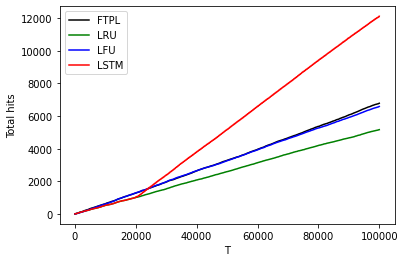

In [13]:
plt.plot(hits_FTPL,'black',label='FTPL')
plt.plot(hits_LRU,'green',label='LRU')
plt.plot(hits_LFU,'blue',label='LFU')
plt.plot(hits_LSTM,'red',label='LSTM')
plt.xlabel('T')
plt.ylabel('Total hits')
plt.legend()
plt.savefig('Total hits(I=J=1).png')

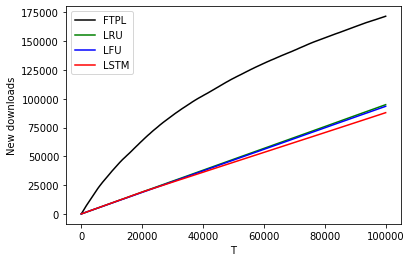

In [14]:
plt.plot(download_FTPL,'black',label='FTPL')
plt.plot(download_LRU,'green',label='LRU')
plt.plot(download_LFU,'blue',label='LFU')
plt.plot(download_LSTM,'red',label='LSTM')
plt.xlabel('T')
plt.ylabel('New downloads')
plt.legend()
plt.savefig('New downloads(I=J=1).png')

I = 5 J = 3 d = 2

In [20]:
C = 5
I = 5
J = 3
degree = 3
T = 20000

In [21]:
connection = np.zeros((I,J),dtype = int)
i = 0
for j in range(J):
  x = 0
  while x < degree:
    connection[i,j] = 1
    x += 1
    i += 1
    if i == I:
      i = 0
  i = j+1
connection

array([[1, 0, 0],
       [1, 1, 0],
       [1, 1, 1],
       [0, 1, 1],
       [0, 0, 1]])

In [22]:
gen_req1 = np.load('/content/drive/My Drive/gen_req.npy')
req1 = np.load('/content/drive/My Drive/req.npy')
req1 = req1[20000:2005000]
gen_req1 = gen_req1[20000:2005000]

In [23]:
req = np.zeros((I,T),dtype = int)
for i in range(I):
  for j in range(T):
    req[i,j] = req1[(i+1)*(j+1) - 1]
req.shape

(5, 20000)

In [24]:
gen_req = np.zeros((I,T),dtype = int)
for i in range(I):
  for j in range(T):
    gen_req[i,j] = gen_req1[(i+1)*(j+1) - 1]
gen_req.shape

(5, 20000)

In [25]:
y_LRU = np.zeros((J,N),dtype = float)
y_LFU = np.zeros((J,N),dtype = float)
y_FTPL = np.zeros((J,N),dtype = float)
y_LSTM = np.zeros((J,N),dtype = float)
y_LSTM[:,:C] = np.ones((J,C),dtype = float)
y_FTPL[:,:C] = np.ones((J,C),dtype = float)
y_LRU[:,:C] = np.ones((J,C),dtype = float)
y_LFU[:,:C] = np.ones((J,C),dtype = float)

count = np.zeros((N,I),dtype = float)

reward_LSTM =  np.zeros(T)
reward_FTPL =  np.zeros(T)
reward_LRU =  np.zeros(T)
reward_LFU =  np.zeros(T)
hits_FTPL =  []
hits_LRU =  []
hits_LFU =  []
hits_LSTM = []
download_FTPL =  []
download_LRU =  []
download_LFU =  []
download_LSTM = []
miss_LRU =  0
miss_LSTM =  0
miss_LFU =  0
miss_FTPL =  0


req_time = np.zeros((N,I),dtype = float) 
req_time1 = np.zeros((N,I),dtype = float) 

for t in range(T):
  old_FTPL = []
  old_LRU = []
  old_LFU = []
  old_LSTM = []
  new_FTPL = []
  new_LRU = []
  new_LFU = []
  new_LSTM = []
  for j in range(J):
    for k in range(N):
      old_LRU.append(y_LRU[j,k])
      old_LFU.append(y_LFU[j,k])
      old_FTPL.append(y_FTPL[j,k])
      old_LSTM.append(y_LSTM[j,k])
  x_t1 = np.zeros((N,I),dtype = int)
  x_t = np.zeros((N,I),dtype = int)
  for i in range(I):
    x_t[req[i,t],i] += 1
    x_t1[gen_req[i,t],i] += 1
    count[int(req[i,t]),i] += 1
    req_time[int(req[i,t]),i] = t+1
    req_time1[int(gen_req[i,t]),i] = t+1
  
  ireward_LRU =  np.zeros(I)
  ireward_LSTM =  np.zeros(I)
  ireward_LFU =  np.zeros(I)
  ireward_FTPL =  np.zeros(I)
  
  for i in range(I):
    temp1 = np.zeros(N)
    temp2 = np.zeros(N)
    temp3 = np.zeros(N)
    temp4 = np.zeros(N)
    connected_cache = []
    for j in range(J):
      if connection[i,j] == 1:
        connected_cache.append(j)
    for k in range(len(connected_cache)):
      temp1 += y_FTPL[connected_cache[k],:]
      temp2 += y_LFU[connected_cache[k],:]
      temp3 += y_LRU[connected_cache[k],:]
      temp4 += y_LSTM[connected_cache[k],:]
    ireward_FTPL[i] += np.dot(np.minimum(np.ones(N),temp1),x_t[:,i])
    ireward_LFU[i] += np.dot(np.minimum(np.ones(N),temp2),x_t[:,i])
    ireward_LRU[i] += np.dot(np.minimum(np.ones(N),temp3),x_t[:,i])
    ireward_LSTM[i] += np.dot(np.minimum(np.ones(N),temp4),x_t1[:,i])

  reward_FTPL[t] =  np.sum(ireward_FTPL)
  reward_LRU[t] =  np.sum(ireward_LRU)
  reward_LFU[t] =  np.sum(ireward_LFU)
  reward_LSTM[t] =  np.sum(ireward_LSTM)
  reward_LSTMc = np.sum(reward_LSTM)
  reward_FTPLc = np.sum(reward_FTPL)
  reward_LRUc = np.sum(reward_LRU)
  reward_LFUc = np.sum(reward_LFU)


  y_LFU = LFU(y_LFU,x_t,count,connection)
  y_LRU = LRU(y_LRU,x_t,req_time,connection)
  y_LSTM = LRU(y_LSTM,x_t1,req_time1,connection)

  eta = I*pow(4*pi*np.log(N*I),-0.25)*pow((t+1)/(J*degree*C),.5)
  perturbed_count=per_count(eta,count)

  [y_FTPL,z] = Greedy(connection,perturbed_count)
  for j in range(J):
    for k in range(N):
      new_LRU.append(y_LRU[j,k])
      new_LFU.append(y_LFU[j,k])
      new_FTPL.append(y_FTPL[j,k])
      new_LSTM.append(y_LSTM[j,k])
  
#  print(old_LRU)
  miss_FTPL += (np.sum(np.logical_and(new_FTPL,np.logical_not(old_FTPL))))
  miss_LFU += (np.sum(np.logical_and(new_LFU,np.logical_not(old_LFU))))
  miss_LRU += (np.sum(np.logical_and(new_LRU,np.logical_not(old_LRU))))
  miss_LSTM += (np.sum(np.logical_and(new_LSTM,np.logical_not(old_LSTM))))
  download_LFU.append(miss_LFU)
  download_LRU.append(miss_LRU)
  download_FTPL.append(miss_FTPL)
  download_LSTM.append(miss_LSTM)

  hits_LRU.append(reward_LRUc)
  hits_LFU.append(reward_LFUc)
  hits_FTPL.append(reward_FTPLc)
  hits_LSTM.append(reward_LSTMc)

  if t %1000 == 0:
    print(t,download_FTPL[t],download_LFU[t],download_LRU[t],download_LSTM[t],hits_FTPL[t],hits_LFU[t],hits_LRU[t],hits_LSTM[t])

0 14 9 9 9 0.0 0.0 0.0 0.0
1000 13029 8351 8405 8123 410.0 397.0 352.0 529.0
2000 25426 16728 16823 16272 825.0 785.0 719.0 1072.0
3000 37029 25113 25277 24408 1233.0 1149.0 1036.0 1593.0
4000 47643 33411 33673 32549 1661.0 1570.0 1385.0 2135.0
5000 57336 41753 42092 40568 2055.0 1946.0 1718.0 2733.0
6000 66766 50147 50502 48666 2446.0 2312.0 2074.0 3299.0
7000 75853 58474 58871 56769 2881.0 2686.0 2452.0 3848.0
8000 84572 66897 67345 64902 3265.0 3009.0 2776.0 4377.0
9000 93148 75292 75771 72985 3671.0 3378.0 3120.0 4936.0
10000 101468 83738 84279 81058 4073.0 3706.0 3413.0 5515.0
11000 109654 92113 92715 89189 4472.0 4073.0 3751.0 6066.0
12000 117696 100492 101154 97318 4881.0 4423.0 4069.0 6612.0
13000 125350 108906 109594 105336 5257.0 4780.0 4407.0 7188.0
14000 133192 117233 118004 113462 5668.0 5171.0 4753.0 7741.0
15000 140808 125629 126482 121595 6079.0 5539.0 5075.0 8287.0
16000 148180 133976 134883 129700 6482.0 5906.0 5424.0 8856.0
17000 155485 142385 143375 137771 6865.0 62

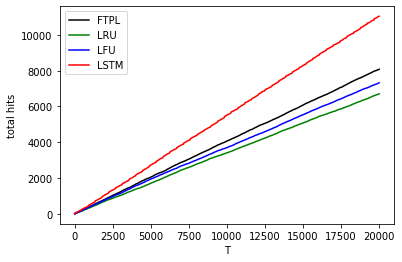

In [26]:
plt.plot(hits_FTPL,'black',label='FTPL')
plt.plot(hits_LRU,'green',label='LRU')
plt.plot(hits_LFU,'blue',label='LFU')
plt.plot(hits_LSTM,'red',label='LSTM')
plt.xlabel('T')
plt.ylabel('total hits')
plt.legend()
plt.savefig('Total hits(I=5 J=3 d=2).png')

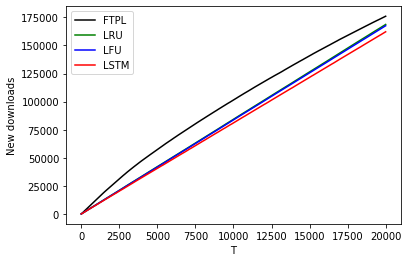

In [27]:
plt.plot(download_FTPL,'black',label='FTPL')
plt.plot(download_LRU,'green',label='LRU')
plt.plot(download_LFU,'blue',label='LFU')
plt.plot(download_LSTM,'red',label='LSTM')
plt.xlabel('T')
plt.ylabel('New downloads')
plt.legend()
plt.savefig('New downloads(I=5 J=3 d=2).png')

I = 15 J = 10 d = 7

In [29]:
I = 15
J = 10
C = 10
degree = 7
T = 5000

In [30]:
connection = np.zeros((I,J),dtype = int)
i = 0
for j in range(J):
  x = 0
  while x < degree:
    connection[i,j] = 1
    x += 1
    i += 1
    if i == I:
      i = 0
  i = j+1
connection

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1]])

In [31]:
gen_req1 = np.load('/content/drive/My Drive/gen_req.npy')
req1 = np.load('/content/drive/My Drive/req.npy')
req1 = req1[20000:2005000]
gen_req1 = gen_req1[20000:2005000]

In [32]:
req = np.zeros((I,T),dtype = int)
for i in range(I):
  for j in range(T):
    req[i,j] = req1[(i+1)*(j+1) - 1]
req.shape

(15, 5000)

In [33]:
gen_req = np.zeros((I,T),dtype = int)
for i in range(I):
  for j in range(T):
    gen_req[i,j] = gen_req1[(i+1)*(j+1) - 1]
gen_req.shape

(15, 5000)

In [34]:
y_LRU = np.zeros((J,N),dtype = float)
y_LFU = np.zeros((J,N),dtype = float)
y_FTPL = np.zeros((J,N),dtype = float)
y_LSTM = np.zeros((J,N),dtype = float)
y_LSTM[:,:C] = np.ones((J,C),dtype = float)
y_FTPL[:,:C] = np.ones((J,C),dtype = float)
y_LRU[:,:C] = np.ones((J,C),dtype = float)
y_LFU[:,:C] = np.ones((J,C),dtype = float)

count = np.zeros((N,I),dtype = float)

reward_LSTM =  np.zeros(T)
reward_FTPL =  np.zeros(T)
reward_LRU =  np.zeros(T)
reward_LFU =  np.zeros(T)
hits_FTPL =  []
hits_LRU =  []
hits_LFU =  []
hits_LSTM = []
download_FTPL =  []
download_LRU =  []
download_LFU =  []
download_LSTM = []
miss_LRU =  0
miss_LSTM =  0
miss_LFU =  0
miss_FTPL =  0


req_time = np.zeros((N,I),dtype = float) 
req_time1 = np.zeros((N,I),dtype = float) 

for t in range(T):
  old_FTPL = []
  old_LRU = []
  old_LFU = []
  old_LSTM = []
  new_FTPL = []
  new_LRU = []
  new_LFU = []
  new_LSTM = []
  for j in range(J):
    for k in range(N):
      old_LRU.append(y_LRU[j,k])
      old_LFU.append(y_LFU[j,k])
      old_FTPL.append(y_FTPL[j,k])
      old_LSTM.append(y_LSTM[j,k])
  x_t1 = np.zeros((N,I),dtype = int)
  x_t = np.zeros((N,I),dtype = int)
  for i in range(I):
    x_t[req[i,t],i] += 1
    x_t1[gen_req[i,t],i] += 1
    count[int(req[i,t]),i] += 1
    req_time[int(req[i,t]),i] = t+1
    req_time1[int(gen_req[i,t]),i] = t+1
  
  ireward_LRU =  np.zeros(I)
  ireward_LSTM =  np.zeros(I)
  ireward_LFU =  np.zeros(I)
  ireward_FTPL =  np.zeros(I)
  
  for i in range(I):
    temp1 = np.zeros(N)
    temp2 = np.zeros(N)
    temp3 = np.zeros(N)
    temp4 = np.zeros(N)
    connected_cache = []
    for j in range(J):
      if connection[i,j] == 1:
        connected_cache.append(j)
    for k in range(len(connected_cache)):
      temp1 += y_FTPL[connected_cache[k],:]
      temp2 += y_LFU[connected_cache[k],:]
      temp3 += y_LRU[connected_cache[k],:]
      temp4 += y_LSTM[connected_cache[k],:]
    ireward_FTPL[i] += np.dot(np.minimum(np.ones(N),temp1),x_t[:,i])
    ireward_LFU[i] += np.dot(np.minimum(np.ones(N),temp2),x_t[:,i])
    ireward_LRU[i] += np.dot(np.minimum(np.ones(N),temp3),x_t[:,i])
    ireward_LSTM[i] += np.dot(np.minimum(np.ones(N),temp4),x_t1[:,i])

  reward_FTPL[t] =  np.sum(ireward_FTPL)
  reward_LRU[t] =  np.sum(ireward_LRU)
  reward_LFU[t] =  np.sum(ireward_LFU)
  reward_LSTM[t] =  np.sum(ireward_LSTM)
  reward_LSTMc = np.sum(reward_LSTM)
  reward_FTPLc = np.sum(reward_FTPL)
  reward_LRUc = np.sum(reward_LRU)
  reward_LFUc = np.sum(reward_LFU)


  y_LFU = LFU(y_LFU,x_t,count,connection)
  y_LRU = LRU(y_LRU,x_t,req_time,connection)
  y_LSTM = LRU(y_LSTM,x_t1,req_time1,connection)

  eta = I*pow(4*pi*np.log(N*I),-0.25)*pow((t+1)/(J*degree*C),.5)
  perturbed_count=per_count(eta,count)

  [y_FTPL,z] = Greedy(connection,perturbed_count)
  for j in range(J):
    for k in range(N):
      new_LRU.append(y_LRU[j,k])
      new_LFU.append(y_LFU[j,k])
      new_FTPL.append(y_FTPL[j,k])
      new_LSTM.append(y_LSTM[j,k])
  
#  print(old_LRU)
  miss_FTPL += (np.sum(np.logical_and(new_FTPL,np.logical_not(old_FTPL))))
  miss_LFU += (np.sum(np.logical_and(new_LFU,np.logical_not(old_LFU))))
  miss_LRU += (np.sum(np.logical_and(new_LRU,np.logical_not(old_LRU))))
  miss_LSTM += (np.sum(np.logical_and(new_LSTM,np.logical_not(old_LSTM))))
  download_LFU.append(miss_LFU)
  download_LRU.append(miss_LRU)
  download_FTPL.append(miss_FTPL)
  download_LSTM.append(miss_LSTM)

  hits_LRU.append(reward_LRUc)
  hits_LFU.append(reward_LFUc)
  hits_FTPL.append(reward_FTPLc)
  hits_LSTM.append(reward_LSTMc)

  if t %100 == 0:
    print(t,download_FTPL[t],download_LFU[t],download_LRU[t],download_LSTM[t],hits_FTPL[t],hits_LFU[t],hits_LRU[t],hits_LSTM[t])

0 100 63 63 54 1.0 1.0 1.0 0.0
100 6529 6003 6010 5739 401.0 322.0 298.0 348.0
200 13804 11981 12049 11771 766.0 625.0 571.0 601.0
300 20747 18025 18246 17681 1086.0 885.0 784.0 887.0
400 27602 24057 24358 23682 1415.0 1135.0 1004.0 1156.0
500 34156 29908 30283 29321 1729.0 1417.0 1276.0 1493.0
600 40867 35889 36308 35277 2073.0 1669.0 1523.0 1767.0
700 47537 41902 42407 41171 2407.0 1932.0 1770.0 2047.0
800 53907 47946 48532 47102 2724.0 2192.0 1994.0 2307.0
900 60196 53977 54575 52860 3035.0 2451.0 2240.0 2638.0
1000 66572 60008 60686 58821 3357.0 2714.0 2477.0 2909.0
1100 72867 65915 66633 64771 3676.0 3000.0 2739.0 3191.0
1200 79052 71892 72692 70602 3992.0 3285.0 2994.0 3498.0
1300 85143 77904 78821 76543 4316.0 3550.0 3233.0 3772.0
1400 91212 83929 84897 82138 4659.0 3807.0 3475.0 4154.0
1500 97031 89952 90991 88125 4997.0 4084.0 3728.0 4406.0
1600 102696 95891 97088 93977 5330.0 4368.0 3976.0 4694.0
1700 108370 101936 103198 99855 5625.0 4630.0 4216.0 4991.0
1800 113851 107956 1

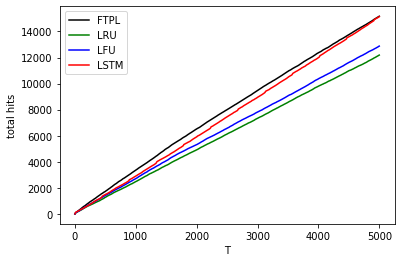

In [35]:
plt.plot(hits_FTPL,'black',label='FTPL')
plt.plot(hits_LRU,'green',label='LRU')
plt.plot(hits_LFU,'blue',label='LFU')
plt.plot(hits_LSTM,'red',label='LSTM')
plt.xlabel('T')
plt.ylabel('total hits')
plt.legend()
plt.savefig('Total hits(I=15 J=10 d=7).png')

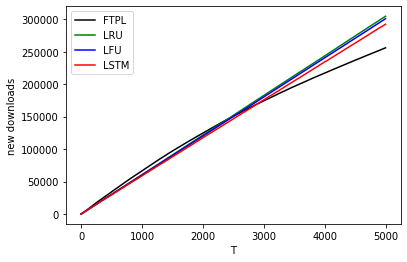

In [36]:
plt.plot(download_FTPL,'black',label='FTPL')
plt.plot(download_LRU,'green',label='LRU')
plt.plot(download_LFU,'blue',label='LFU')
plt.plot(download_LSTM,'red',label='LSTM')
plt.xlabel('T')
plt.ylabel('new downloads')
plt.legend()
plt.savefig('New downloads(I=15 J=10 d=7).png')